In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
import csv
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn import cross_validation
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import AdaBoostClassifier
%matplotlib inline

C:\Users\lin\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:
df = pd.read_csv('data_sequel.csv')
df['Year_of_Release'] = df['Year_of_Release'].convert_objects(convert_numeric= True)
df['User_Score'] = df['User_Score'].convert_objects(convert_numeric= True)
def is_1mi(x):
    if x>=1:
        return 1
    else:
        return 0

df['Million'] = df['Global_Sales']
df.drop('Global_Sales', axis=1, inplace=True)
df['Million'] = df['Million'].apply(lambda x:is_1mi(x))
# Classify games by whether it's global sales exceed 1 million

df = df[['Platform', 'Year_of_Release', 'Genre', 'Publisher','Critic_Score', 'Critic_Count','Developer', 'Rating', 'Sequel', 'Million']]
df = df[pd.notnull(df['Year_of_Release'])]
df['Year_of_Release']  = df['Year_of_Release'].astype('int64') 
#  convert Year_of_Release to int and drop nan values

df = df[-df['Rating'].isin(['AO','EC','K-A','RP'])]

# Data for AO, EC K-A, RP is very sparse. So for precision we drump them from data.
top40 = df['Developer'].value_counts().iloc[:40].index.tolist()
def is_top40(Developer):
    if Developer in top40:
        return 1
    else:
        return 0 
df['Top_Developer'] = df['Developer'].map(is_top40)
# TOP 40 Developer's game average sale is almost twice over the rest of developer's 
# So We divided them by top 40 and others

df = df.dropna().reset_index(drop=True)

C:\Users\lin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  
C:\Users\lin\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
df_copy = pd.get_dummies(df)

In [10]:
df_copy.head()

,Year_of_Release,Critic_Score,Critic_Count,Sequel,Million,Top_Developer,Platform_3DS,Platform_DC,Platform_DS,Platform_GBA,...,Developer_n-Space,Developer_neo Software,Developer_odenis studio,Developer_oeFun,Developer_syn Sophia,Developer_zSlide,Rating_E,Rating_E10+,Rating_M,Rating_T
0,2006,76.0,51.0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,2008,82.0,73.0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,2009,80.0,73.0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,2006,89.0,65.0,0,1,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,2006,58.0,41.0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [11]:
def get_acu_with_prob(df):
    y = df['Million'].values
    df = df.drop(['Million'],axis=1)
    X = df.values
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.10, random_state=2)
    #####
    radm = RandomForestClassifier(n_estimators=1000,
                                  max_depth=None,
                                  min_samples_split=10,
                                  class_weight="balanced",
                                  random_state=2).fit(Xtrain, ytrain)
    y_val_1 = radm.predict_proba(Xtest)
    fpr_1, tpr_1, thresholds_1 = metrics.roc_curve(ytest, pd.DataFrame(y_val_1)[1].values, pos_label=1)
    radm_roc_auc = roc_auc_score(ytest, radm.predict(Xtest))
    print("Random Forest Validation accuracy: ", sum(pd.DataFrame(y_val_1).idxmax(axis=1).values
                                       == ytest)/len(ytest))
    print ('auc:', metrics.auc(fpr_1, tpr_1))
    #####

    log_reg = LogisticRegression().fit(Xtrain, ytrain)
    y_val_2 = log_reg.predict_proba(Xtest)
    fpr_2, tpr_2, thresholds_2 = metrics.roc_curve(ytest, pd.DataFrame(y_val_2)[1].values, pos_label=1)
    log_roc_auc = roc_auc_score(ytest, log_reg.predict(Xtest))
    print("Logistic Regression Validation accuracy: ", sum(pd.DataFrame(y_val_2).idxmax(axis=1).values
                                       == ytest)/len(ytest))
    print ('auc:', metrics.auc(fpr_2, tpr_2))
    #####
    gnb = GaussianNB().fit(Xtrain,ytrain)
    y_val_3 = gnb.predict(Xtest)
    fpr_3, tpr_3, thresholds_3 = metrics.roc_curve(ytest, y_val_3, pos_label=1)
    gnb_roc_auc = roc_auc_score(ytest, gnb.predict(Xtest))
    print("Naive Bayes Validation accuracy: ", sum(y_val_3==ytest)/len(ytest))
    print ('auc:', metrics.auc(fpr_3, tpr_3))
    #####
    kNN = KNeighborsClassifier(n_neighbors=25).fit(Xtrain, ytrain)
    y_val_4 = kNN.predict(Xtest)
    y_prob_4 = kNN.predict_proba(Xtest)
    fpr_4, tpr_4, thresholds_4 = metrics.roc_curve(ytest, pd.DataFrame(y_prob_4)[1].values, pos_label=1)
    acu =  sum(y_val_4==ytest)/len(ytest)
    kNN_roc_auc = roc_auc_score(ytest, kNN.predict(Xtest))
    print("kNN Validation accuracy: ",acu)
    print ('auc:', metrics.auc(fpr_4, tpr_4))
    ####
    svm = SVC(C=249,kernel='rbf',probability = True).fit(Xtrain,ytrain)
    val_5 = svm.predict(Xtest)
    val_prob_5 = svm.predict_proba(Xtest)
    fpr_5, tpr_5, thresholds_5 = metrics.roc_curve(ytest, pd.DataFrame(val_prob_5)[1].values, pos_label=1)
    svm_roc_auc = roc_auc_score(ytest, svm.predict(Xtest))
    print("SVM Validation accuracy: ", sum(val_5==ytest)/len(ytest))
    print ('auc:', metrics.auc(fpr_5, tpr_5))
    ####
    ada = AdaBoostClassifier(n_estimators=400, learning_rate=0.1).fit(Xtrain,ytrain)
    ada_roc_auc = roc_auc_score(ytest, ada.predict(Xtest))
    val_6 = ada.predict(Xtest)
    val_prob_6 = ada.predict_proba(Xtest)
    fpr_6, tpr_6, thresholds_6 = metrics.roc_curve(ytest, pd.DataFrame(val_prob_6)[1], pos_label=1)
    ada_roc_auc = roc_auc_score(ytest, ada.predict(Xtest))
    print("ADA Validation accuracy: ", sum(val_6==ytest)/len(ytest))
    print("AdaBoost AUC = %2.2f" % ada_roc_auc)
    
    
    

    plt.figure()

    # Plot Random Forest ROC
    plt.plot(fpr_1, tpr_1, label='Random Forest (area = %0.2f)' % metrics.auc(fpr_1, tpr_1))

    # Plot Logistic Regression ROC
    plt.plot(fpr_2, tpr_2, label=' (Logistic Regression area = %0.2f)' % metrics.auc(fpr_2, tpr_2))

    
    # Plot kNN ROC
    plt.plot(fpr_4, tpr_4, label='KNN (area = %0.2f)' % metrics.auc(fpr_4, tpr_4))
    
    # Plot SVM ROC
    plt.plot(fpr_5, tpr_5, label='SVM (area = %0.2f)' % metrics.auc(fpr_5, tpr_5))
    
    # Plot ADA ROC
    plt.plot(fpr_6, tpr_6, label='ada (area = %0.2f)' % metrics.auc(fpr_6, tpr_6))

    # Plot Base Rate ROC
    plt.plot([0,1], [0,1],label='Base Rate' 'k--')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Graph')
    plt.legend(loc="lower right")
    plt.show()

Random Forest Validation accuracy:  0.876558603491
auc: 0.905619629127
Logistic Regression Validation accuracy:  0.88029925187
auc: 0.895194482135
Naive Bayes Validation accuracy:  0.529925187032
auc: 0.676074174582
kNN Validation accuracy:  0.860349127182
auc: 0.824711668928
SVM Validation accuracy:  0.895261845387
auc: 0.89262777024
ADA Validation accuracy:  0.866583541147
AdaBoost AUC = 0.67


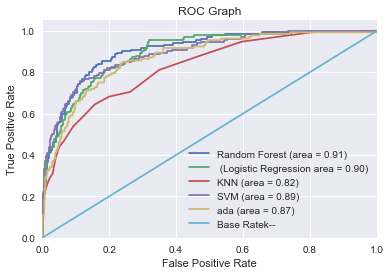

In [12]:
get_acu_with_prob(df_copy)

In [21]:
test = df_copy[-9:].drop('Million',axis =1)

In [23]:
y = df_copy['Million'].values
df = df_copy.drop(['Million'],axis=1)
X = df.values
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.10, random_state=2)
#####
radm = RandomForestClassifier(n_estimators=1000,
                                  max_depth=None,
                                  min_samples_split=10,
                                  class_weight="balanced",
                                  random_state=2).fit(Xtrain, ytrain)
y_val_1 = radm.predict_proba(test)

In [24]:
y_val_1

array([[ 0.25181414,  0.74818586],
       [ 0.23398364,  0.76601636],
       [ 0.74418738,  0.25581262],
       [ 0.77680492,  0.22319508],
       [ 0.90677006,  0.09322994],
       [ 0.76305761,  0.23694239],
       [ 0.77680492,  0.22319508],
       [ 0.17157467,  0.82842533],
       [ 0.34454761,  0.65545239]])

In [22]:
test

,Year_of_Release,Critic_Score,Critic_Count,Sequel,Top_Developer,Platform_3DS,Platform_DC,Platform_DS,Platform_GBA,Platform_GC,...,Developer_n-Space,Developer_neo Software,Developer_odenis studio,Developer_oeFun,Developer_syn Sophia,Developer_zSlide,Rating_E,Rating_E10+,Rating_M,Rating_T
8008,2017,89.0,115.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8009,2017,80.0,83.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8010,2017,89.0,23.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8011,2017,79.0,79.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8012,2017,69.0,20.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8013,2017,77.0,55.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8014,2017,79.0,79.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8015,2017,96.0,13.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8016,2017,76.0,27.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [1]:
pwd

'C:\\Users\\lin\\Documents\\mycode\\652\\project'